# To-Do May 15

## Make sure Instagram still works

## HMM!

## Look at which variables load onto PCA_0 most strongly...people will want to know
Also if you think that's the "depression" component then it'd be good to back that up


## Find out how many individuals are represented in correct vs incorrect predictions
Eg. do we get some users who always show up in false neg or false pos, or in true pos?  
This might be especially useful for the url and created date analyses, where we don't know the extent to which a subset of usernames might be driving correct classification.  
for those in false pos, look at the actual posts (might be easier for twitter), and maybe even have mturk rate whether they seem depressed or not. are we finding new depressed cases, or are we just wrong?  

## Restrict username analysis to only those individuals with a minimum number of days represented in their observations 
Alternately, min number of posts   
See R code notes for more. (bayes.R)

## Move R code to Jupyter?

In [1]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

import pickle
from skimage import io, data, color
import re
from re import findall,UNICODE

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.linear_model import LogisticRegressionCV as logregcv
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import cross_validation

from scipy.stats import ttest_ind as ttest
from scipy.stats import ttest_rel

from statsmodels.sandbox.stats.multicomp import multipletests

from labMTsimple.speedy import *
from bgfunc import *

import warnings
warnings.filterwarnings("ignore")


loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_may9_649pm.db'
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?  
What sort of analyses or models do we want to run?

In [10]:
platform = 'tw'
platform_long = 'twitter'
condition = 'depression'
test_name = 'cesd'
test_cutoff = 21
photos_rated = True
has_test = True
gb_types = ['created_date','weekly','user_id'] # note "weekly" not "post" as in instagram version
periods = ['before','after']
turn_points = ['from_diag','from_susp']
fields = "id, text, has_url"
clfs = ['lr','rf']

report_sample_size = False # simple reporting feature
load_from_pickle = True # loads entire data dict, including masters, from pickle file
final_pickle = False # pickles entire data dict after all masters are created
populate_wordfeats_db = False # generates word features from reagan code

run_master = False 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': False, 
    'save_to_file' : False, 
    'density' : False, 
    'ml' : True, 
    'nhst' : False, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': True
}

params = define_params(condition, test_name, test_cutoff, platform, platform_long, fields, photos_rated, has_test)

In [4]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

## Load ready data, or prepare raw data

Set load_from_pickle to determine action here.  

In case you don't have a pickled data dict, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle

In [5]:
if load_from_pickle:
    data = pickle.load( open( "data.p", "rb" ) )
    
else:
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, periods, turn_points)
    pickle.dump( data, open( "data.p", "wb" ) )
    

### This next section generates word features from Andy Reagan's code

Only set populate_wordfeats_db = True if you need to redo the features for some reason!
    

In [6]:
if populate_wordfeats_db:
    for pop_long in ['target','control']:
        for tunit in ['user_id','created_date','weekly']:

            print 'In {} :: {}'.format(pop_long,tunit)

            create_word_feats(data[pop_long], tunit, condition, conn, write_to_db=True, testing=False)


## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST

In [8]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'

    if action_params['create_master']:
        master['model'] = {}

    for gb_type in gb_types:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs)

## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

Building ML models...

total vars: 78
cumulative % variance explained per component:
[ 51.27  55.3   57.55  59.54  61.42  63.15  64.7   66.09  67.4   68.64
  69.83  70.99  72.13  73.22  74.29  75.33  76.31  77.28  78.25  79.17
  80.05  80.91  81.75  82.56  83.36  84.13  84.88  85.6   86.3   86.99
  87.65  88.29  88.92  89.51  90.09  90.66  91.22  91.76  92.25  92.74
  93.21  93.68  94.14  94.58  95.01  95.42  95.82  96.17  96.51  96.84
  97.15  97.44  97.73  98.01  98.26  98.5   98.72  98.92  99.11  99.28
  99.41  99.54  99.63  99.7   99.77  99.83  99.88  99.92  99.95  99.96
  99.97  99.98  99.98  99.98  99.98  99.98  99.98  99.98]


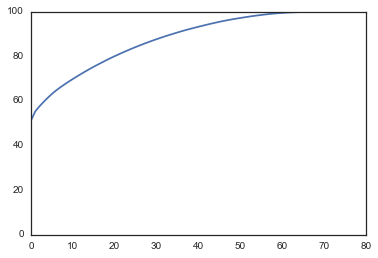

num pca comp displayed: 39
optimal number of components: 40


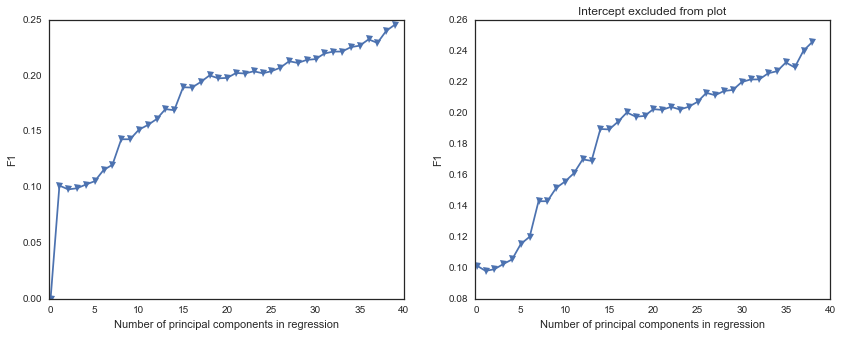


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.694
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_diag created_date):
NAIVE ACCURACY: 0.655

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          3961         1441
known_target           1243         1140

Proportion of pred_target in known_control: 0.267
Proportion of pred_target in known_target: 0.478




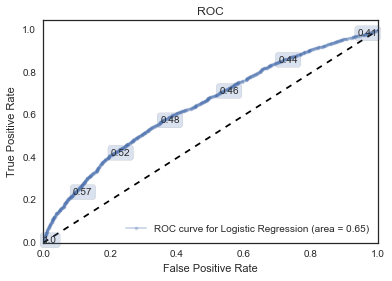

MODEL: Random Forests target (Models: before from_diag created_date):
NAIVE ACCURACY: 0.726

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          5184          218
known_target           1915          468

Proportion of pred_target in known_control: 0.04
Proportion of pred_target in known_target: 0.196




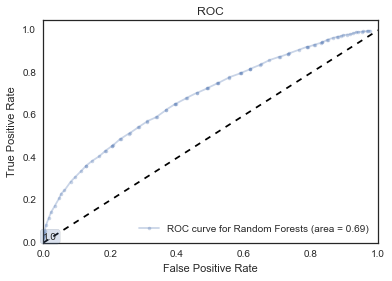

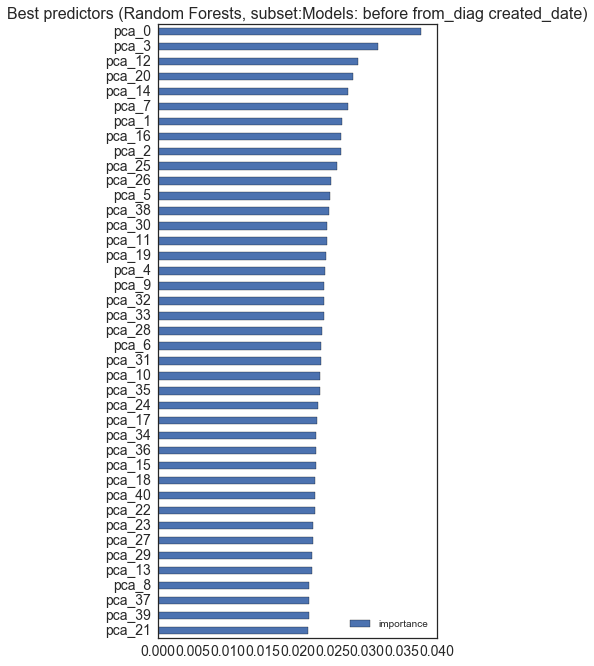

Building ML models...

total vars: 78
cumulative % variance explained per component:
[ 64.49  68.55  70.71  72.6   74.13  75.55  76.75  77.88  78.92  79.93
  80.87  81.76  82.59  83.36  84.11  84.84  85.54  86.2   86.84  87.47
  88.05  88.62  89.17  89.69  90.19  90.68  91.16  91.63  92.07  92.49
  92.89  93.27  93.65  94.02  94.37  94.71  95.03  95.34  95.64  95.93
  96.21  96.48  96.74  96.98  97.22  97.44  97.66  97.86  98.05  98.24
  98.42  98.59  98.75  98.9   99.03  99.16  99.28  99.39  99.49  99.58
  99.66  99.74  99.8   99.84  99.88  99.91  99.94  99.96  99.98 100.   100.
 100.   100.   100.   100.   100.   100.   100.  ]


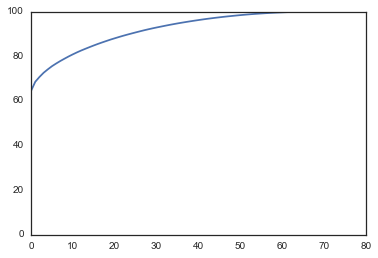

num pca comp displayed: 39
optimal number of components: 40


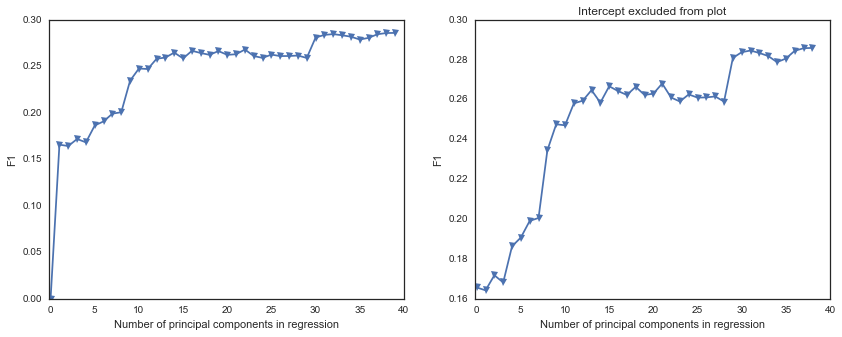


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY
NAIVE ACCURACY ALL NULL: 0.753
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_diag weekly):
NAIVE ACCURACY: 0.691

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1405          496
known_target            284          341

Proportion of pred_target in known_control: 0.261
Proportion of pred_target in known_target: 0.546




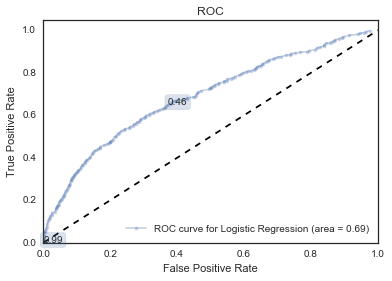

MODEL: Random Forests target (Models: before from_diag weekly):
NAIVE ACCURACY: 0.777

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1841           60
known_target            504          121

Proportion of pred_target in known_control: 0.032
Proportion of pred_target in known_target: 0.194




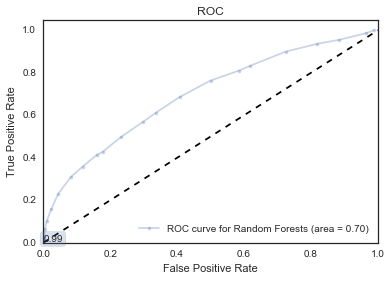

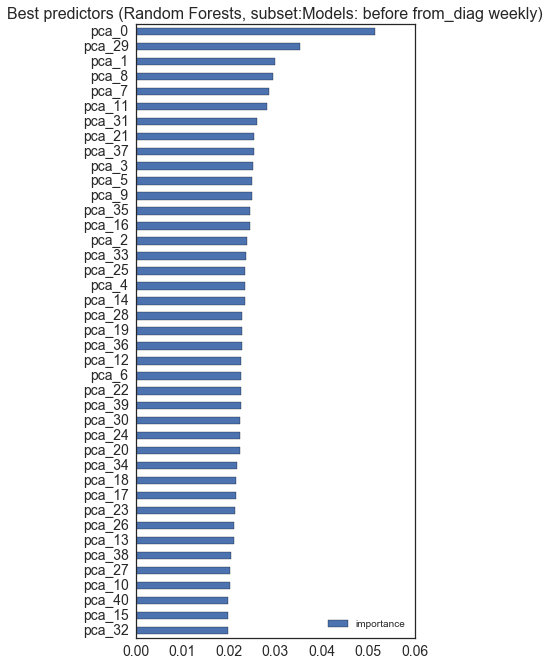

Building ML models...

total vars: 72
cumulative % variance explained per component:
[ 78.67  82.35  85.04  86.86  88.29  89.68  90.62  91.53  92.24  92.91
  93.5   94.04  94.55  94.99  95.36  95.69  96.01  96.31  96.57  96.81
  97.04  97.26  97.45  97.63  97.8   97.95  98.09  98.23  98.36  98.47
  98.58  98.68  98.78  98.87  98.96  99.04  99.11  99.18  99.25  99.32
  99.38  99.44  99.49  99.54  99.59  99.63  99.67  99.71  99.74  99.77
  99.8   99.83  99.85  99.87  99.89  99.91  99.93  99.95  99.96  99.97
  99.98  99.99 100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.  ]


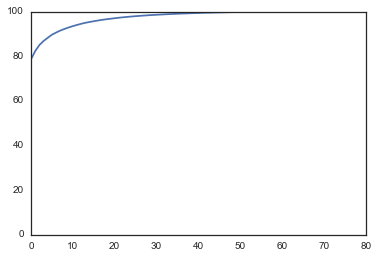

num pca comp displayed: 36
optimal number of components: 18


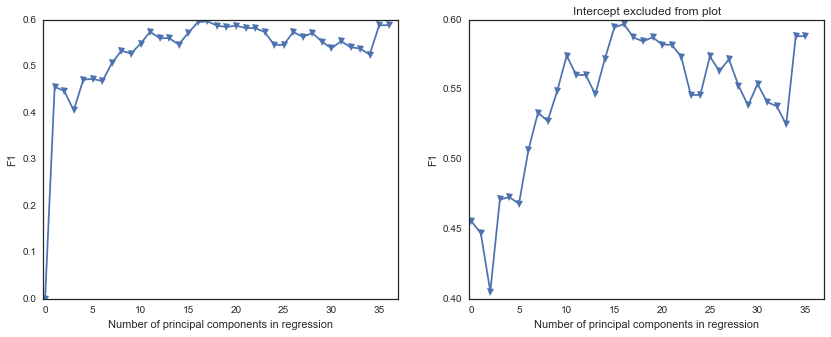


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USER_ID
NAIVE ACCURACY ALL NULL: 0.558
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_diag user_id):
NAIVE ACCURACY: 0.75

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            22            7
known_target              6           17

Proportion of pred_target in known_control: 0.241
Proportion of pred_target in known_target: 0.739




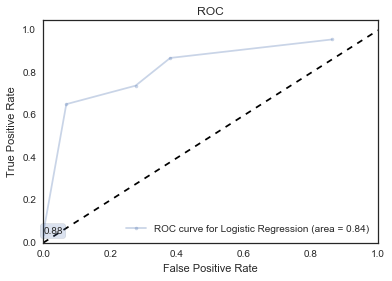

MODEL: Random Forests target (Models: before from_diag user_id):
NAIVE ACCURACY: 0.712

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            25            4
known_target             11           12

Proportion of pred_target in known_control: 0.138
Proportion of pred_target in known_target: 0.522




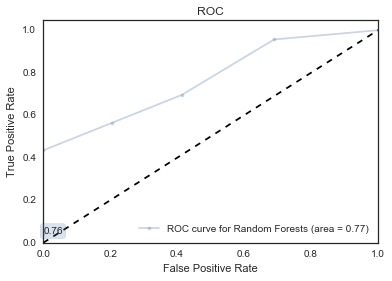

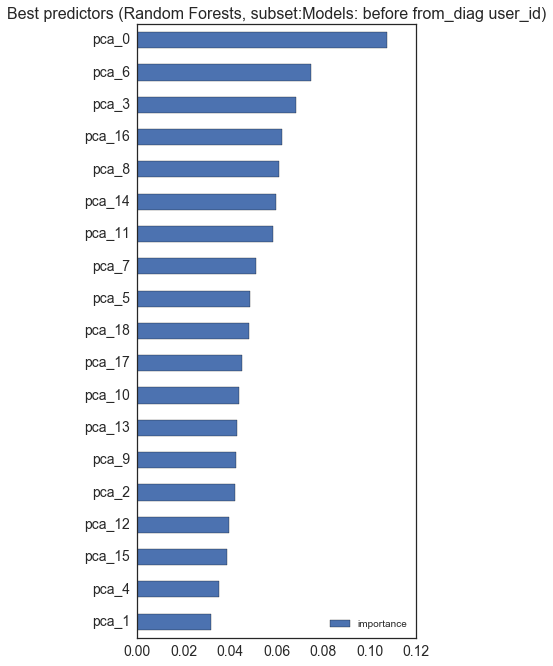

Building ML models...

total vars: 78
cumulative % variance explained per component:
[  48.76   52.85   55.2    57.22   59.08   60.88   62.49   63.92   65.3
   66.63   67.9    69.09   70.24   71.37   72.48   73.57   74.63   75.67
   76.68   77.67   78.61   79.53   80.43   81.3    82.15   82.98   83.76
   84.52   85.27   86.01   86.71   87.38   88.04   88.68   89.3    89.9
   90.5    91.06   91.6    92.12   92.63   93.13   93.63   94.1    94.56
   95.01   95.44   95.83   96.2    96.56   96.89   97.21   97.52   97.82
   98.1    98.35   98.59   98.81   99.01   99.21   99.36   99.5    99.59
   99.67   99.75   99.82   99.88   99.93   99.96   99.97   99.98   99.99
  100.    100.    100.    100.    100.    100.  ]


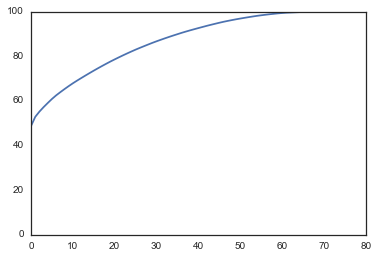

num pca comp displayed: 39
optimal number of components: 37


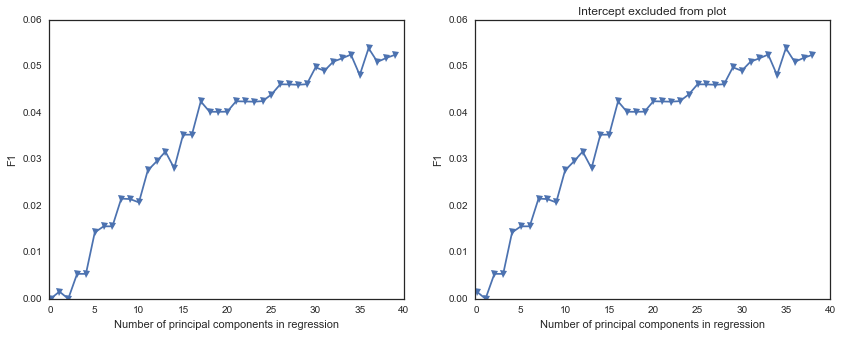


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.879
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_susp created_date):
NAIVE ACCURACY: 0.726

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          4162         1300
known_target            400          352

Proportion of pred_target in known_control: 0.238
Proportion of pred_target in known_target: 0.468




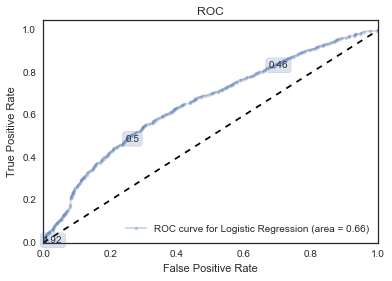

MODEL: Random Forests target (Models: before from_susp created_date):
NAIVE ACCURACY: 0.891

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          5453            9
known_target            671           81

Proportion of pred_target in known_control: 0.002
Proportion of pred_target in known_target: 0.108




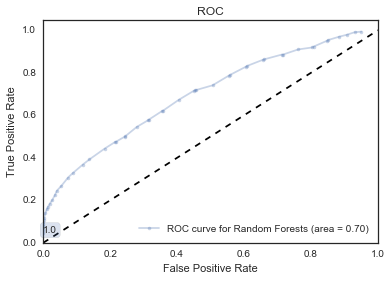

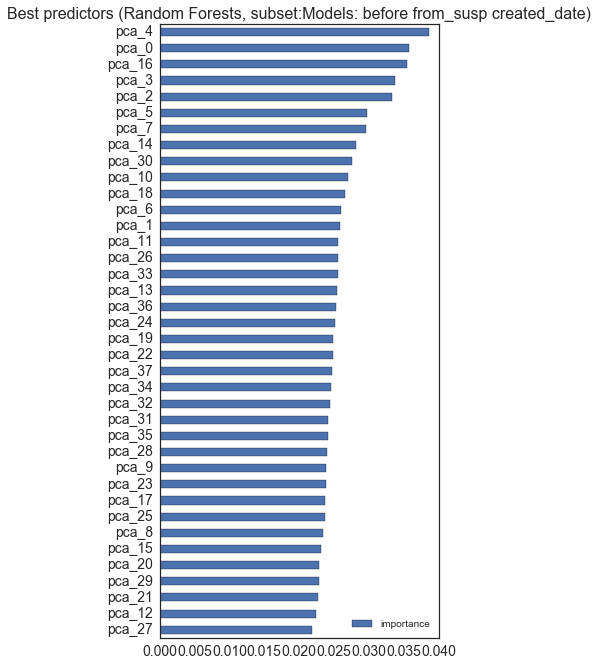

Building ML models...

total vars: 78
cumulative % variance explained per component:
[ 62.12  66.16  68.36  70.21  71.82  73.28  74.55  75.72  76.81  77.85
  78.82  79.77  80.65  81.5   82.3   83.07  83.81  84.55  85.25  85.91
  86.56  87.2   87.82  88.39  88.95  89.5   90.04  90.56  91.05  91.53  92.
  92.43  92.85  93.26  93.65  94.03  94.39  94.74  95.08  95.41  95.73
  96.04  96.34  96.61  96.87  97.12  97.36  97.59  97.81  98.02  98.22
  98.41  98.6   98.77  98.92  99.07  99.2   99.32  99.43  99.53  99.62
  99.7   99.77  99.83  99.87  99.91  99.94  99.96  99.98 100.   100.   100.
 100.   100.   100.   100.   100.   100.  ]


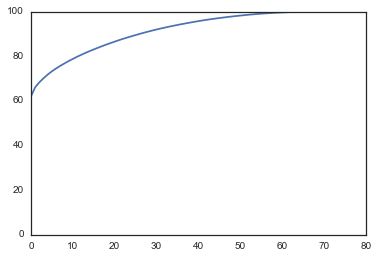

num pca comp displayed: 39
optimal number of components: 40


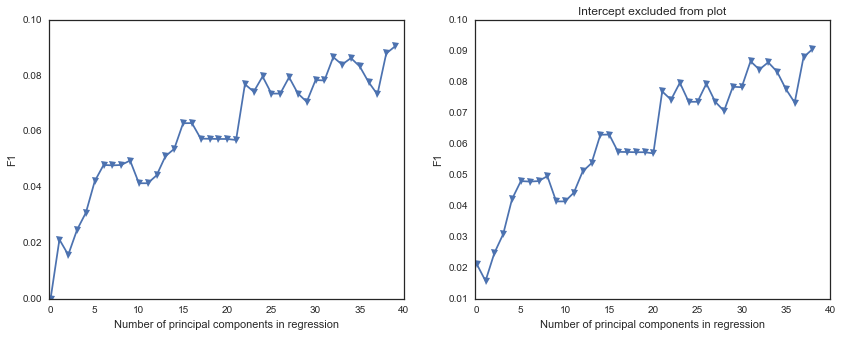


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY
NAIVE ACCURACY ALL NULL: 0.9
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_susp weekly):
NAIVE ACCURACY: 0.713

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1379          511
known_target             92          118

Proportion of pred_target in known_control: 0.27
Proportion of pred_target in known_target: 0.562




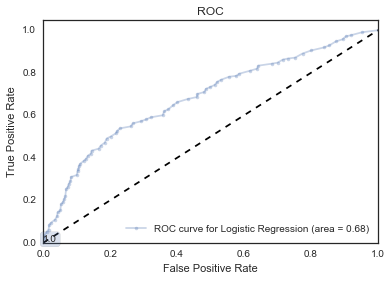

MODEL: Random Forests target (Models: before from_susp weekly):
NAIVE ACCURACY: 0.905

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1888            2
known_target            198           12

Proportion of pred_target in known_control: 0.001
Proportion of pred_target in known_target: 0.057




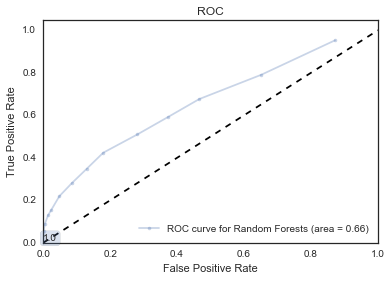

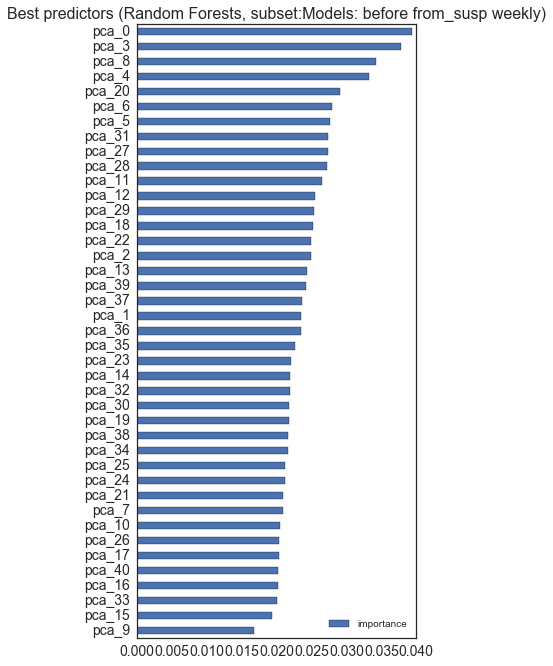

Building ML models...

total vars: 72
cumulative % variance explained per component:
[  76.68   80.58   83.25   85.     86.62   88.11   89.15   90.08   90.88
   91.63   92.3    92.89   93.46   93.96   94.41   94.82   95.22   95.6
   95.95   96.27   96.56   96.83   97.08   97.31   97.52   97.71   97.89
   98.06   98.2    98.34   98.46   98.57   98.68   98.79   98.89   98.99
   99.07   99.15   99.23   99.3    99.37   99.43   99.49   99.54   99.59
   99.64   99.68   99.72   99.76   99.8    99.83   99.86   99.88   99.9
   99.92   99.94   99.96   99.97   99.98   99.99  100.    100.01  100.01
  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01]


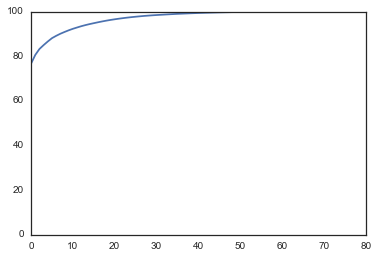

num pca comp displayed: 36
optimal number of components: 8


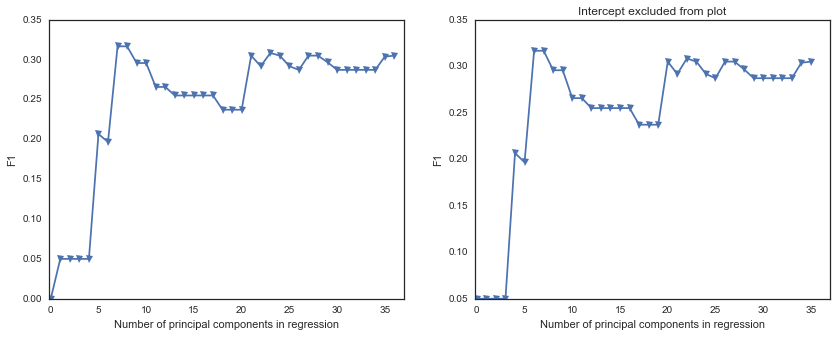


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USER_ID
NAIVE ACCURACY ALL NULL: 0.861
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before from_susp user_id):
NAIVE ACCURACY: 0.833

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            27            4
known_target              2            3

Proportion of pred_target in known_control: 0.129
Proportion of pred_target in known_target: 0.6




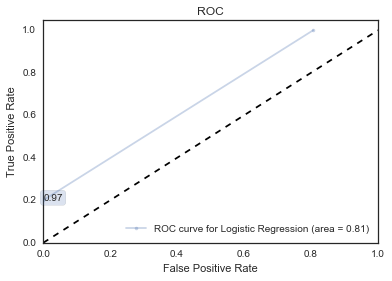

MODEL: Random Forests target (Models: before from_susp user_id):
NAIVE ACCURACY: 0.889

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            31            0
known_target              4            1

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.2




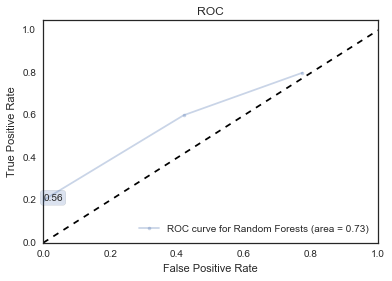

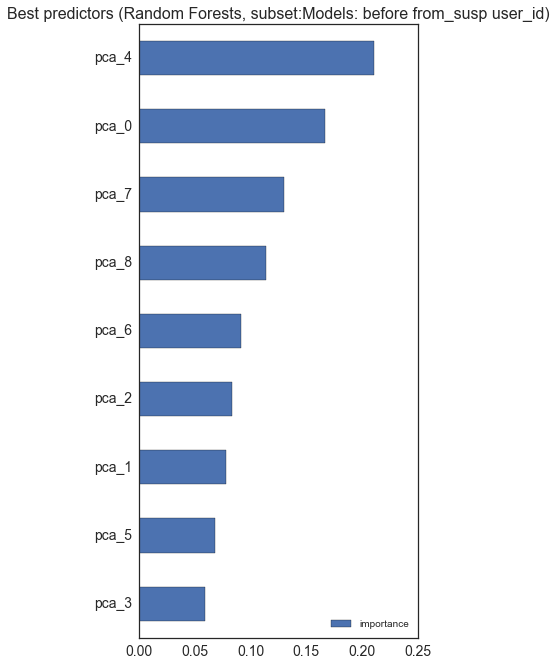

Building ML models...

total vars: 78
cumulative % variance explained per component:
[  57.36   61.51   63.68   65.68   67.39   68.95   70.37   71.6    72.75
   73.85   74.92   75.98   76.98   77.93   78.85   79.75   80.61   81.44
   82.25   83.03   83.76   84.48   85.16   85.83   86.48   87.12   87.74
   88.34   88.93   89.51   90.06   90.59   91.11   91.62   92.12   92.58
   93.03   93.47   93.89   94.29   94.68   95.06   95.43   95.79   96.13
   96.46   96.77   97.06   97.33   97.59   97.84   98.07   98.29   98.51
   98.71   98.89   99.06   99.22   99.36   99.49   99.6    99.69   99.77
   99.82   99.87   99.91   99.94   99.97   99.99  100.    100.01  100.01
  100.01  100.01  100.01  100.01  100.01  100.01]


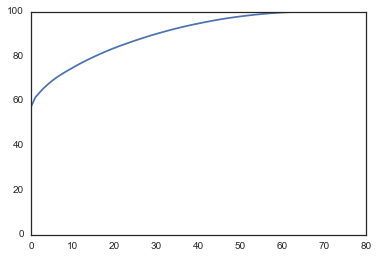

num pca comp displayed: 39
optimal number of components: 37


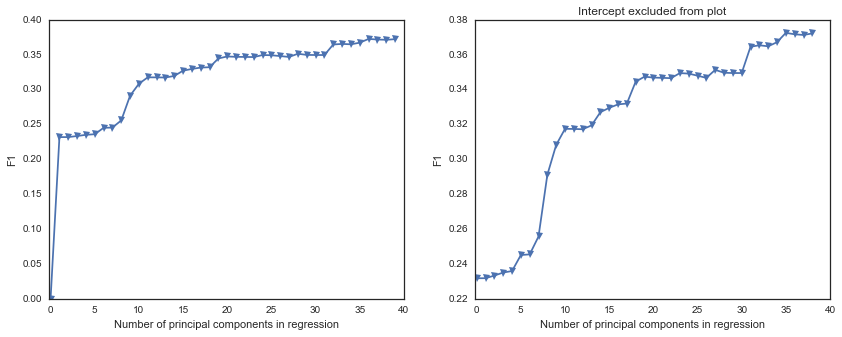


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.682
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_diag created_date):
NAIVE ACCURACY: 0.674

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          4242         1246
known_target           1381         1177

Proportion of pred_target in known_control: 0.227
Proportion of pred_target in known_target: 0.46




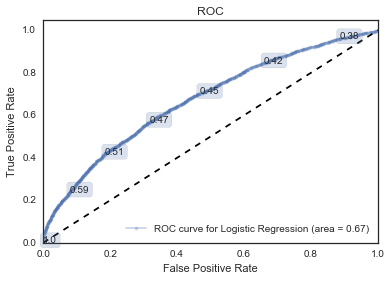

MODEL: Random Forests target (Models: after from_diag created_date):
NAIVE ACCURACY: 0.727

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          5062          426
known_target           1770          788

Proportion of pred_target in known_control: 0.078
Proportion of pred_target in known_target: 0.308




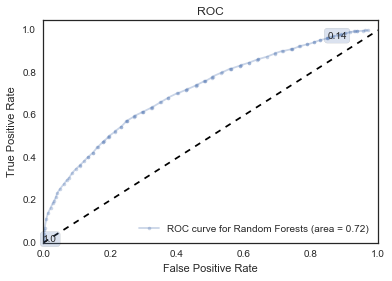

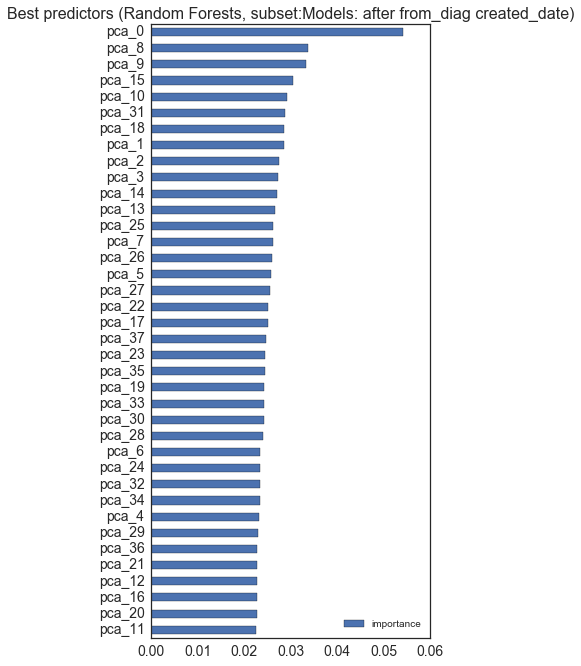

Building ML models...

total vars: 78
cumulative % variance explained per component:
[ 68.24  72.51  74.7   76.82  78.33  79.65  80.79  81.86  82.87  83.74
  84.54  85.28  86.01  86.72  87.4   88.05  88.66  89.24  89.76  90.25
  90.7   91.15  91.58  91.99  92.38  92.77  93.14  93.5   93.85  94.17
  94.49  94.81  95.1   95.38  95.65  95.91  96.16  96.4   96.63  96.86
  97.08  97.28  97.48  97.66  97.84  98.01  98.18  98.34  98.49  98.63
  98.76  98.89  99.01  99.13  99.23  99.33  99.42  99.51  99.59  99.66
  99.73  99.79  99.84  99.87  99.89  99.91  99.93  99.95  99.96  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97]


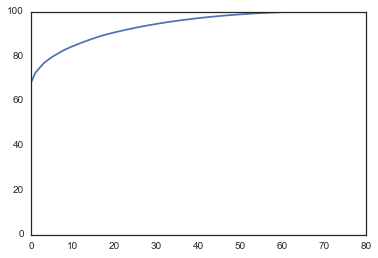

num pca comp displayed: 39
optimal number of components: 40


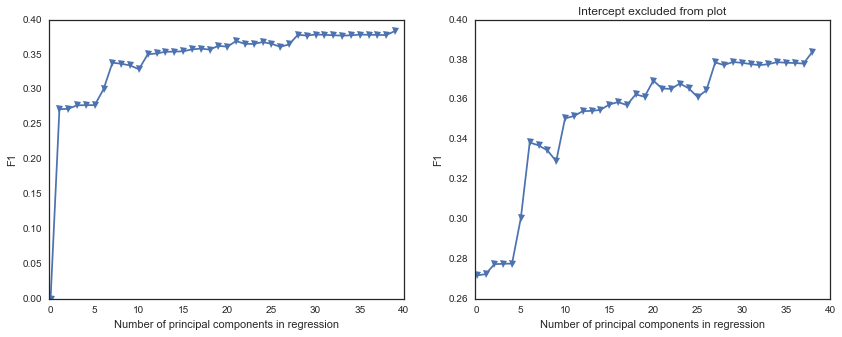


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY
NAIVE ACCURACY ALL NULL: 0.746
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_diag weekly):
NAIVE ACCURACY: 0.707

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1461          460
known_target            295          358

Proportion of pred_target in known_control: 0.239
Proportion of pred_target in known_target: 0.548




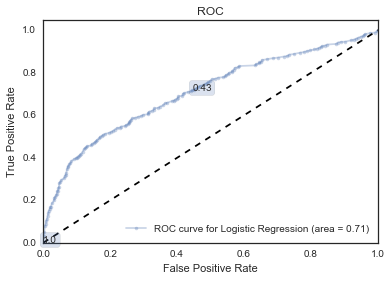

MODEL: Random Forests target (Models: after from_diag weekly):
NAIVE ACCURACY: 0.787

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1834           87
known_target            462          191

Proportion of pred_target in known_control: 0.045
Proportion of pred_target in known_target: 0.292




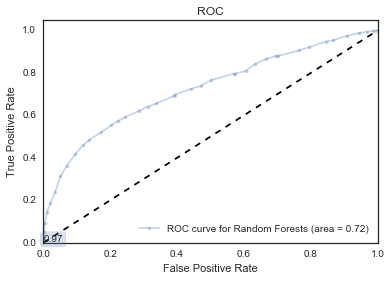

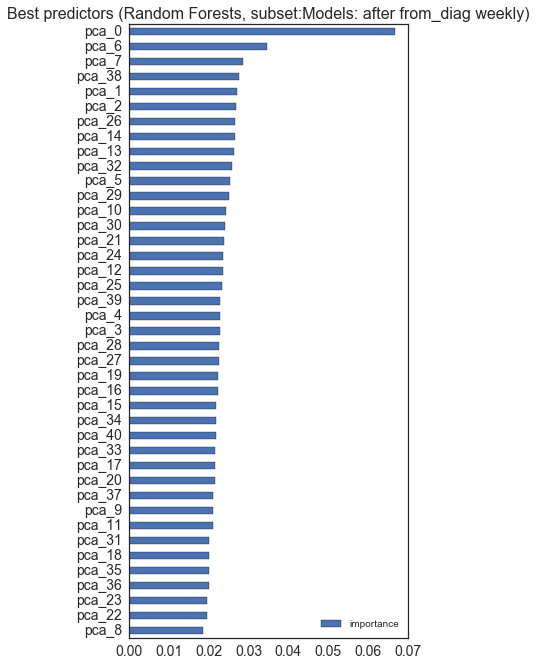

Building ML models...

total vars: 72
cumulative % variance explained per component:
[  78.77   83.97   86.39   88.39   89.69   90.83   91.8    92.62   93.3
   93.93   94.45   94.92   95.33   95.67   95.98   96.27   96.53   96.77
   96.99   97.2    97.41   97.59   97.76   97.92   98.07   98.21   98.34
   98.46   98.57   98.67   98.76   98.85   98.94   99.02   99.1    99.17
   99.24   99.3    99.36   99.42   99.47   99.52   99.57   99.61   99.65
   99.69   99.72   99.75   99.78   99.81   99.84   99.86   99.88   99.9
   99.92   99.94   99.96   99.97   99.98   99.99  100.    100.01  100.01
  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01]


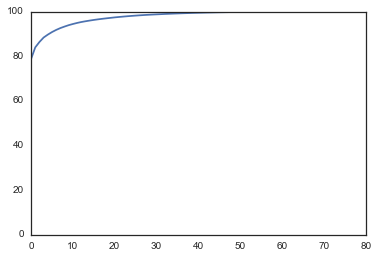

num pca comp displayed: 36
optimal number of components: 13


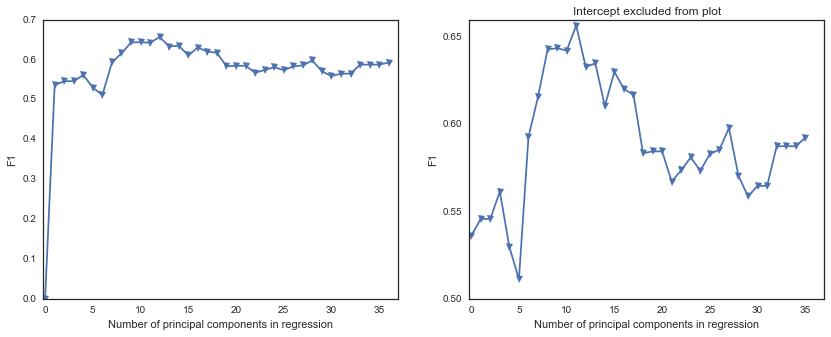


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USER_ID
NAIVE ACCURACY ALL NULL: 0.509
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_diag user_id):
NAIVE ACCURACY: 0.649

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            19           10
known_target             10           18

Proportion of pred_target in known_control: 0.345
Proportion of pred_target in known_target: 0.643




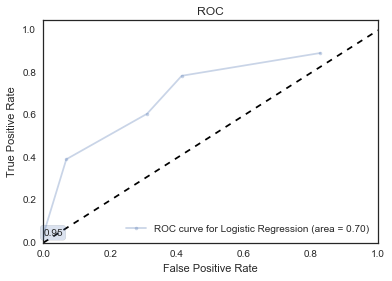

MODEL: Random Forests target (Models: after from_diag user_id):
NAIVE ACCURACY: 0.684

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            22            7
known_target             11           17

Proportion of pred_target in known_control: 0.241
Proportion of pred_target in known_target: 0.607




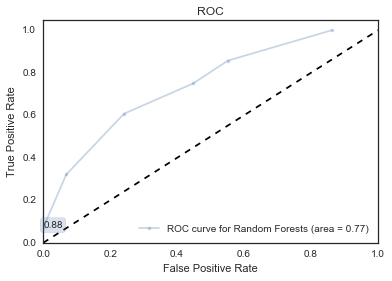

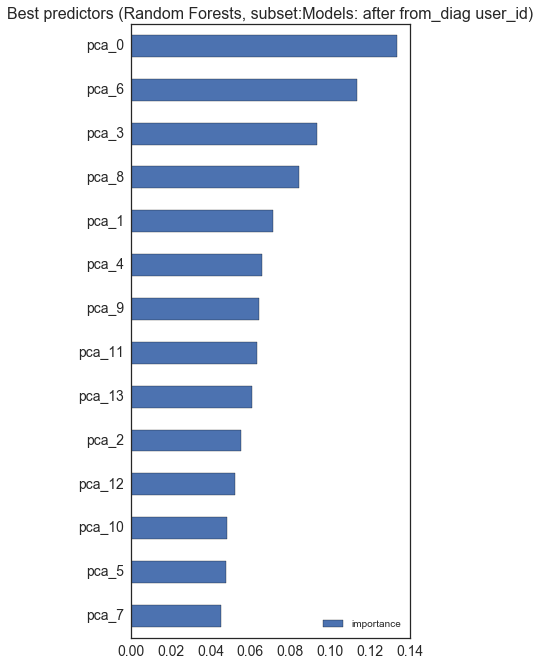

Building ML models...

total vars: 78
cumulative % variance explained per component:
[  50.99   55.14   57.44   59.38   61.25   62.96   64.52   65.9    67.19
   68.43   69.64   70.8    71.9    72.99   74.06   75.11   76.12   77.12
   78.08   79.01   79.92   80.78   81.62   82.44   83.23   84.01   84.76
   85.47   86.17   86.86   87.52   88.16   88.79   89.39   89.97   90.54
   91.1    91.65   92.16   92.66   93.16   93.63   94.09   94.54   94.98
   95.4    95.8    96.18   96.52   96.85   97.16   97.45   97.74   98.02
   98.28   98.51   98.73   98.93   99.12   99.3    99.44   99.57   99.66
   99.73   99.8    99.86   99.91   99.95   99.98   99.99  100.    100.01
  100.01  100.01  100.01  100.01  100.01  100.01]


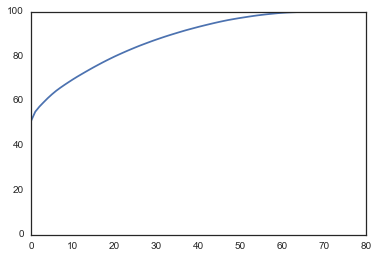

num pca comp displayed: 39
optimal number of components: 39


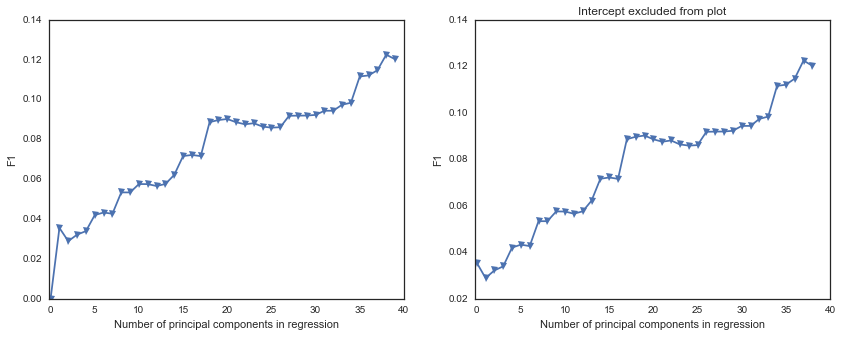


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.838
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_susp created_date):
NAIVE ACCURACY: 0.701

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          3945         1458
known_target            469          572

Proportion of pred_target in known_control: 0.27
Proportion of pred_target in known_target: 0.549




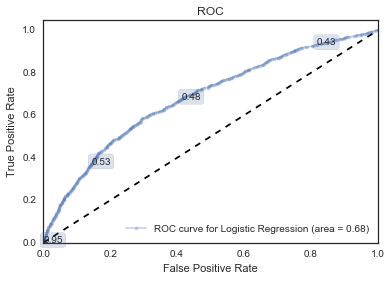

MODEL: Random Forests target (Models: after from_susp created_date):
NAIVE ACCURACY: 0.85

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          5376           27
known_target            939          102

Proportion of pred_target in known_control: 0.005
Proportion of pred_target in known_target: 0.098




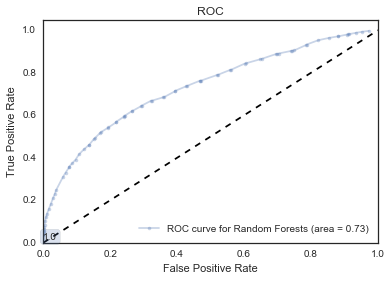

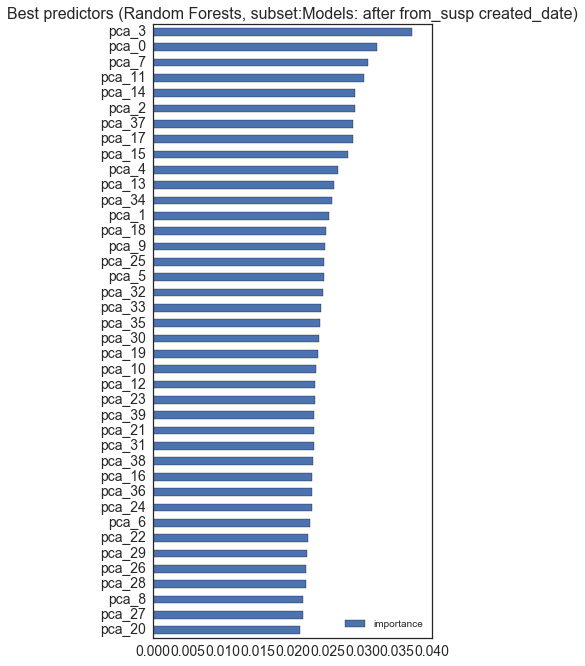

Building ML models...

total vars: 78
cumulative % variance explained per component:
[  63.79   67.91   70.1    72.01   73.55   74.98   76.21   77.38   78.47
   79.43   80.37   81.26   82.09   82.89   83.66   84.4    85.12   85.8
   86.46   87.09   87.69   88.28   88.84   89.38   89.9    90.41   90.9
   91.37   91.82   92.25   92.68   93.09   93.47   93.85   94.22   94.58
   94.91   95.23   95.54   95.85   96.14   96.41   96.68   96.93   97.17
   97.4    97.62   97.83   98.03   98.22   98.4    98.57   98.74   98.89
   99.03   99.16   99.28   99.39   99.49   99.58   99.67   99.75   99.81
   99.85   99.88   99.91   99.94   99.96   99.98  100.    100.    100.
  100.    100.    100.    100.    100.    100.  ]


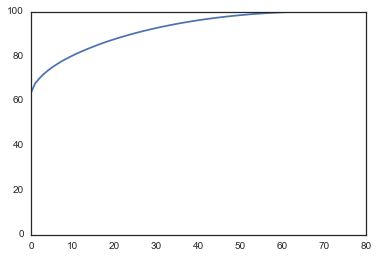

num pca comp displayed: 39
optimal number of components: 38


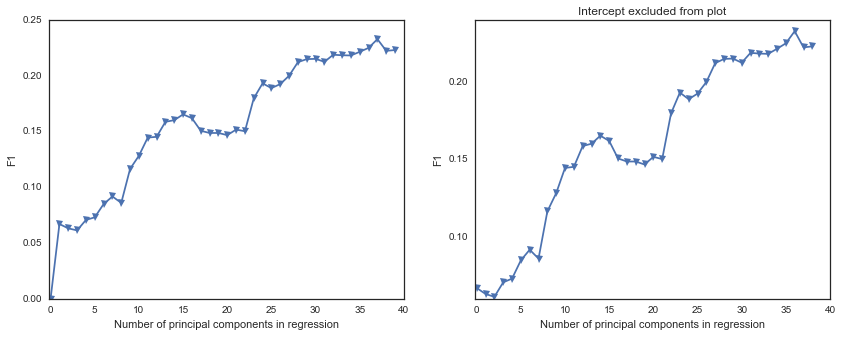


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY
NAIVE ACCURACY ALL NULL: 0.886
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_susp weekly):
NAIVE ACCURACY: 0.743

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1462          441
known_target            110          135

Proportion of pred_target in known_control: 0.232
Proportion of pred_target in known_target: 0.551




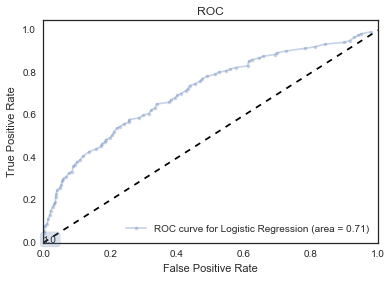

MODEL: Random Forests target (Models: after from_susp weekly):
NAIVE ACCURACY: 0.898

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1900            3
known_target            216           29

Proportion of pred_target in known_control: 0.002
Proportion of pred_target in known_target: 0.118




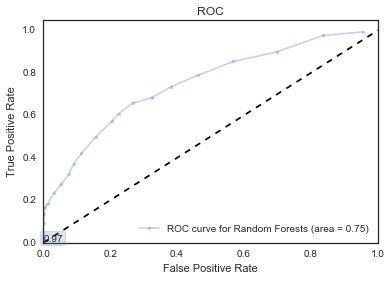

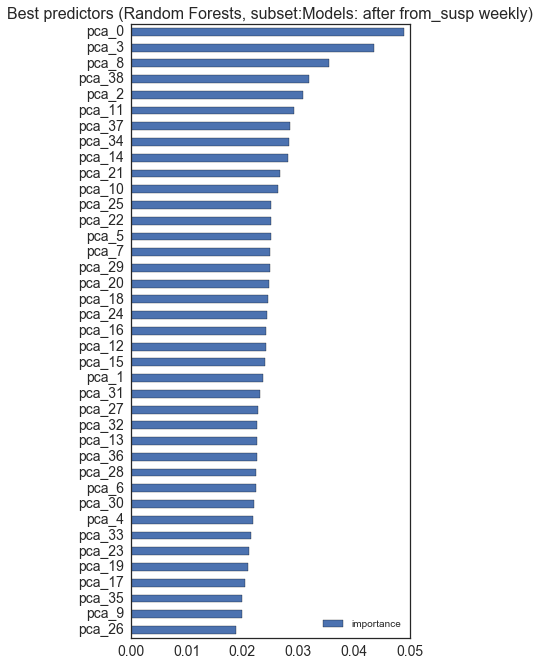

Building ML models...

total vars: 72
cumulative % variance explained per component:
[  78.09   81.7    84.3    85.99   87.43   88.85   89.9    90.79   91.57
   92.29   92.92   93.51   94.03   94.54   94.94   95.31   95.67   96.01
   96.32   96.61   96.88   97.12   97.34   97.54   97.72   97.9    98.06
   98.21   98.35   98.48   98.59   98.69   98.79   98.89   98.98   99.07
   99.15   99.22   99.29   99.35   99.41   99.47   99.52   99.57   99.62
   99.66   99.7    99.74   99.77   99.8    99.83   99.86   99.88   99.9
   99.92   99.94   99.95   99.96   99.97   99.98   99.99  100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.  ]


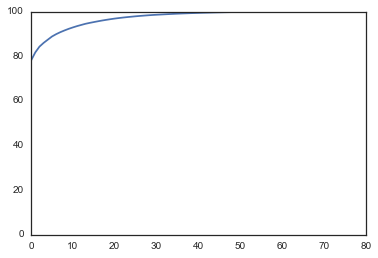

num pca comp displayed: 36
optimal number of components: 8


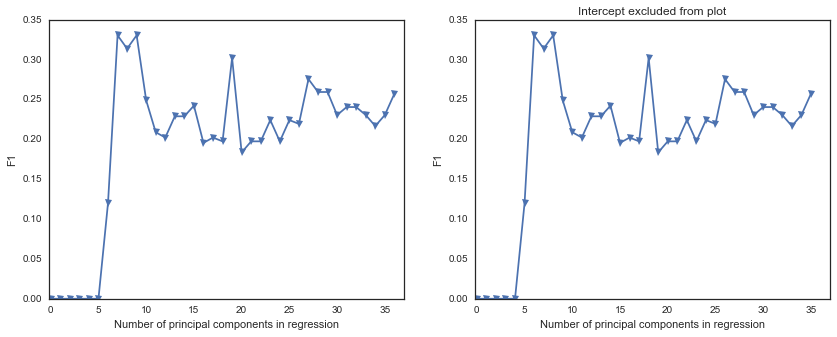


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USER_ID
NAIVE ACCURACY ALL NULL: 0.684
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after from_susp user_id):
NAIVE ACCURACY: 0.605

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            16           10
known_target              5            7

Proportion of pred_target in known_control: 0.385
Proportion of pred_target in known_target: 0.583




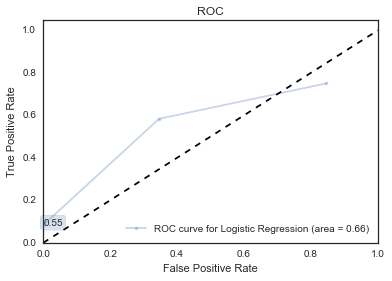

MODEL: Random Forests target (Models: after from_susp user_id):
NAIVE ACCURACY: 0.763

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            26            0
known_target              9            3

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.25




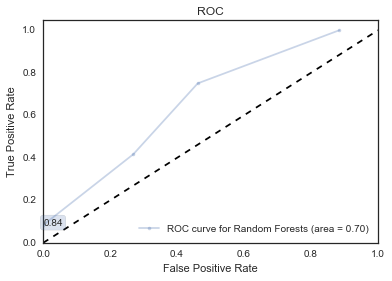

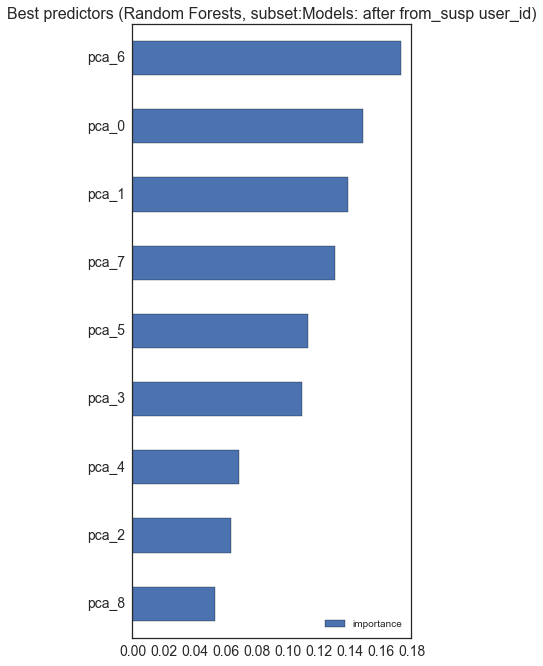

In [11]:
if run_subsets:
    for period in periods:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in turn_points:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{} {}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in gb_types:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {}'.format(period.upper(), turn_point.upper(), gb_type.upper())
                # merge target, control, into master
                master_actions(master, target, control, condition,
                               platform, params, gb_type, report,
                               action_params, clfs, 
                               use_pca=True) # using PCA!

In [10]:
if final_pickle:
    pickle.dump( data, open( "data.p", "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point

In [14]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow

for gb_type in ['created_date','weekly']: 
    before_vs_after(data['target']['gb'], gb_type, platform, condition, params['vars'][platform], action_params)


before vs after (target: depression) for created_date-groupby, based on diag_date:

before vs after (target: depression) for created_date-groupby, based on susp_date:

before vs after (target: depression) for weekly-groupby, based on diag_date:

before vs after (target: depression) for weekly-groupby, based on susp_date:


### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: created_date

total vars: 78
cumulative % variance explained per component:
[  56.74   60.82   62.98   64.97   66.71   68.3    69.73   70.98   72.14
   73.24   74.33   75.4    76.42   77.39   78.33   79.24   80.11   80.95
   81.77   82.57   83.32   84.06   84.76   85.45   86.12   86.77   87.4
   88.02   88.62   89.21   89.78   90.32   90.85   91.37   91.87   92.35
   92.82   93.27   93.7    94.1    94.5    94.89   95.27   95.63   95.98
   96.32   96.65   96.95   97.22   97.49   97.75   97.99   98.22   98.44
   98.65   98.84   99.01   99.17   99.32   99.45   99.56   99.66   99.75
   99.8    99.85   99.9    99.93   99.96   99.99  100.    100.01  100.01
  100.01  100.01  100.01  100.01  100.01  100.01]


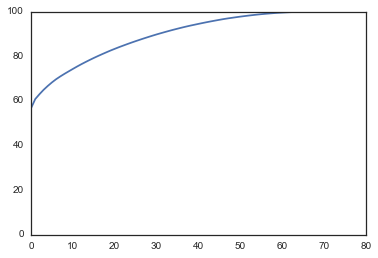

num pca comp displayed: 39
optimal number of components: 34


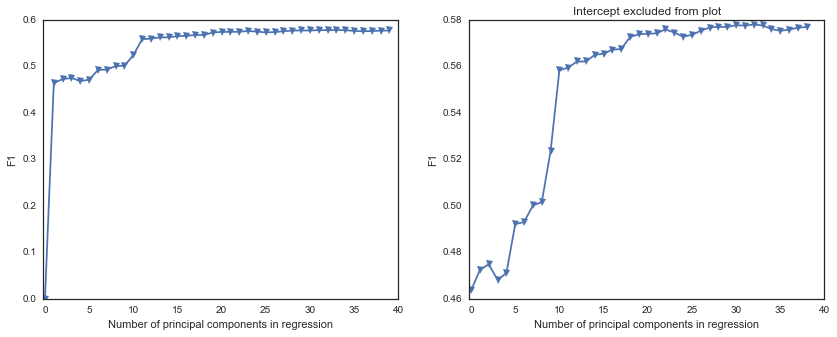


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.528
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: PCA MAIN created_date):
NAIVE ACCURACY: 0.631

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          3754         1737
known_target           2106         2806

Proportion of pred_target in known_control: 0.316
Proportion of pred_target in known_target: 0.571




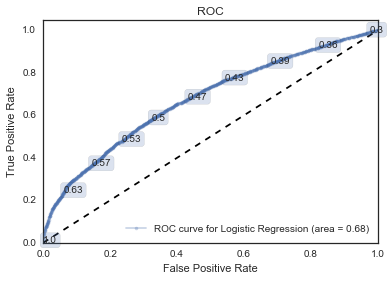

MODEL: Random Forests target (Models: PCA MAIN created_date):
NAIVE ACCURACY: 0.646

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          3836         1655
known_target           2024         2888

Proportion of pred_target in known_control: 0.301
Proportion of pred_target in known_target: 0.588




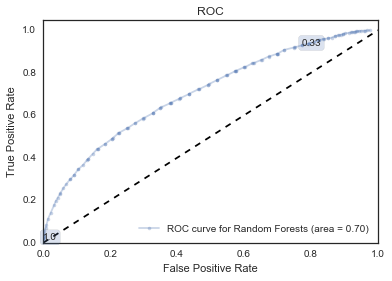

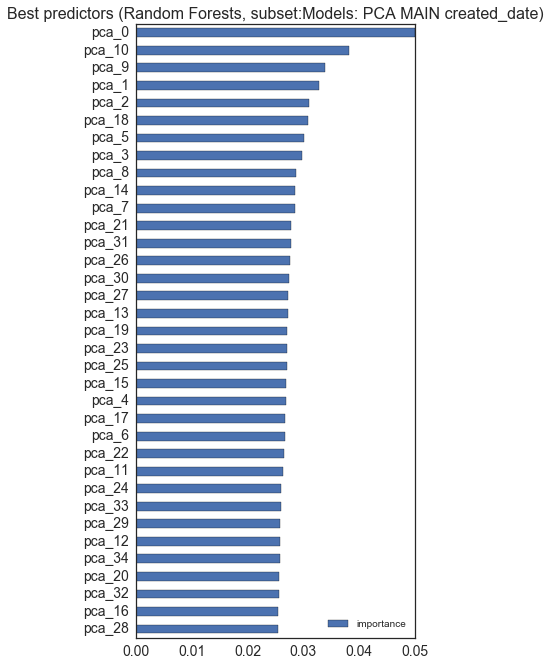

RUNNING PCA: weekly

total vars: 78
cumulative % variance explained per component:
[  68.07   72.29   74.48   76.55   78.03   79.39   80.52   81.6    82.62
   83.48   84.28   85.05   85.79   86.5    87.18   87.83   88.45   89.04
   89.55   90.05   90.52   90.98   91.43   91.84   92.25   92.65   93.03
   93.39   93.75   94.08   94.4    94.72   95.02   95.31   95.58   95.85
   96.11   96.35   96.59   96.82   97.05   97.25   97.45   97.64   97.82
   98.     98.17   98.33   98.48   98.63   98.77   98.9    99.02   99.14
   99.25   99.35   99.45   99.54   99.63   99.71   99.78   99.84   99.89
   99.92   99.95   99.97   99.99  100.01  100.02  100.03  100.03  100.03
  100.03  100.03  100.03  100.03  100.03  100.03]


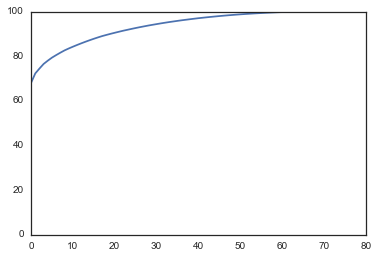

num pca comp displayed: 39
optimal number of components: 40


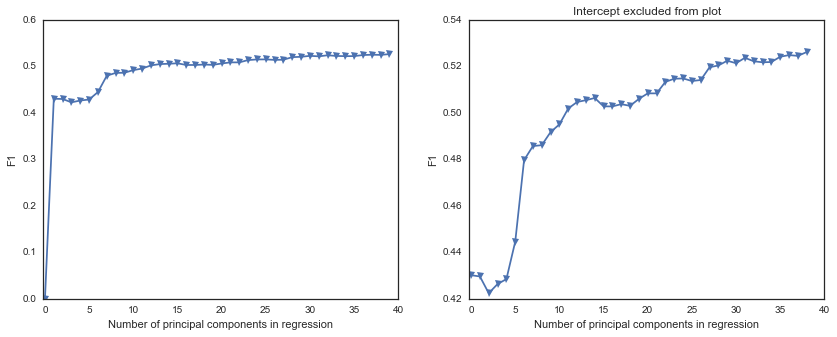


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY
NAIVE ACCURACY ALL NULL: 0.594
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: PCA MAIN weekly):
NAIVE ACCURACY: 0.662

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1441          452
known_target            624          670

Proportion of pred_target in known_control: 0.239
Proportion of pred_target in known_target: 0.518




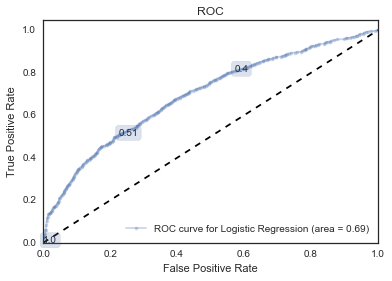

MODEL: Random Forests target (Models: PCA MAIN weekly):
NAIVE ACCURACY: 0.685

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1623          270
known_target            735          559

Proportion of pred_target in known_control: 0.143
Proportion of pred_target in known_target: 0.432




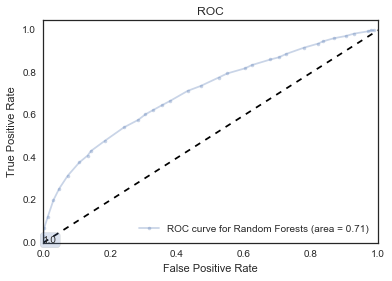

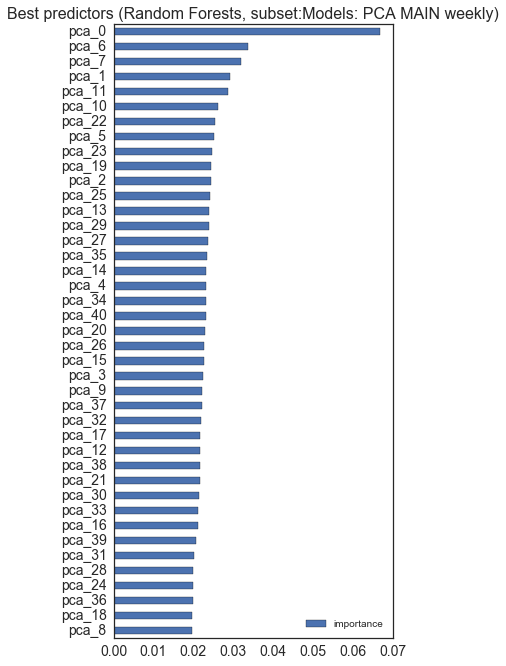

RUNNING PCA: user_id

total vars: 72
cumulative % variance explained per component:
[  78.98   84.17   86.58   88.57   89.91   91.01   92.01   92.84   93.47
   94.08   94.6    95.06   95.44   95.78   96.09   96.36   96.62   96.85
   97.06   97.26   97.46   97.64   97.8    97.95   98.09   98.23   98.36
   98.48   98.59   98.69   98.78   98.87   98.96   99.04   99.12   99.19
   99.25   99.31   99.37   99.43   99.48   99.53   99.57   99.61   99.65
   99.69   99.72   99.75   99.78   99.81   99.84   99.86   99.88   99.9
   99.92   99.94   99.96   99.97   99.98   99.99  100.    100.01  100.01
  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01]


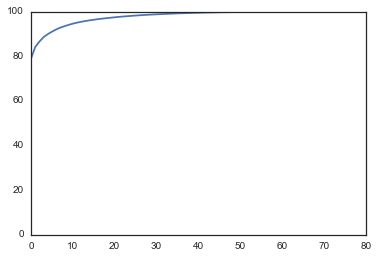

num pca comp displayed: 36
optimal number of components: 14


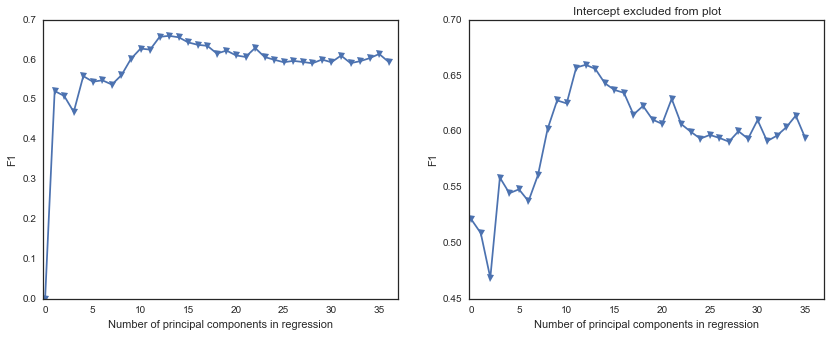


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USER_ID
NAIVE ACCURACY ALL NULL: 0.526
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: PCA MAIN user_id):
NAIVE ACCURACY: 0.632

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            22            8
known_target             13           14

Proportion of pred_target in known_control: 0.267
Proportion of pred_target in known_target: 0.519




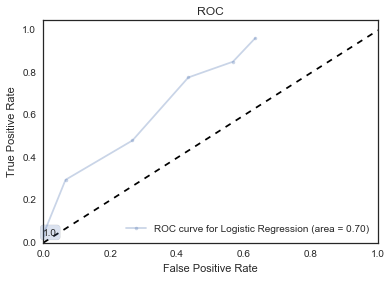

MODEL: Random Forests target (Models: PCA MAIN user_id):
NAIVE ACCURACY: 0.667

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            23            7
known_target             12           15

Proportion of pred_target in known_control: 0.233
Proportion of pred_target in known_target: 0.556




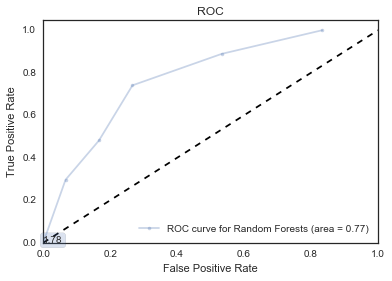

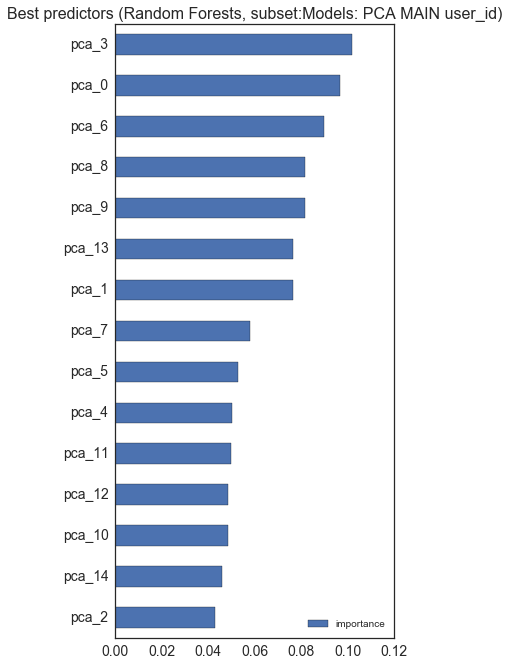

In [52]:
if run_separate_pca:
    master = data['master']
    report = 'PCA MAIN'
    clfs = ['lr','rf']

    for gb_type in gb_types:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'tall_plot':action_params['tall_plot']
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        make_models2(model_df, 
                    clf_types=clfs, excluded_set=excluded_set, 
                    tall_plot=model_df['tall_plot'], 
                    pca=True)